In [29]:
#1: Imports and Setup
#%pip install pandas numpy seaborn matplotlib scikit-learn xgboost lightgbm river joblib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from river import compose, linear_model, preprocessing, metrics, ensemble
import joblib
import os
import warnings
warnings.filterwarnings("ignore")

In [30]:
#2: Load and Merge Data
data_dir = "./assets"
train_transaction_path = os.path.join(data_dir, "train_transaction.csv")
train_identity_path = os.path.join(data_dir, "train_identity.csv")

df_train = pd.read_csv(train_transaction_path)
df_identity = pd.read_csv(train_identity_path)
df = df_train.merge(df_identity, on="TransactionID", how="left")


In [31]:
# 3: Data Cleaning - Handling Missing Values

# Option 1: Fill missing values with -999
df_filled = df.copy()
df_filled.fillna(-999, inplace=True)

# Option 2: Drop rows with any missing values
df_dropped = df.copy()
df_dropped.dropna(inplace=True)

#Label Encoding for Categorical Columns
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))


In [32]:
#4: Feature Selection and Splitting
features = [
    "TransactionAmt", "card1", "card2", "dist1", "C1", "C2", "D1", "V1", "V2"
]

X = df[features]
y = df["isFraud"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

#Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [33]:
#5: Model Training with Evaluation
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    "LightGBM": LGBMClassifier()
}

best_model = None
best_score = 0

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    proba = model.predict_proba(X_test_scaled)[:, 1]
    auc = roc_auc_score(y_test, proba)
    print(f"\n{name} Report:")
    print(classification_report(y_test, y_pred, digits=4))
    print("ROC AUC:", roc_auc_score(y_test, proba))
    if auc > best_score:
        best_score = auc
        best_model = model

joblib.dump(best_model, "best_fraud_detection_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(features, "features.pkl")
print(f"\nBest Model: {best_model.__class__.__name__} with ROC AUC: {best_score}")


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
#6: Evaluation of Best Model
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score

# Predict with the best model
y_pred_test = best_model.predict(X_test_scaled)
y_proba_test = best_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation metrics
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_proba_test)

print("\nEvaluation of Best Model:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visual Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Best Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
# #6: Online Learning using River

from river import preprocessing as rv_pre
from river import compose as rv_comp
from river import metrics as rv_metrics
from river import linear_model
from tqdm import tqdm

# Sample a manageable portion of data for online simulation
stream_df = df.sample(10000, random_state=42).copy()

# Ensure consistent feature usage
stream_df = stream_df[["isFraud"] + features]

# Initialize the online model pipeline
online_model = rv_comp.Pipeline(
    ('scale', rv_pre.StandardScaler()),
    ('model', linear_model.LogisticRegression())
)

# Initialize metrics
acc = rv_metrics.Accuracy()
rocauc = rv_metrics.ROCAUC()

# Tracking for results
correct = 0
total = 0

# Warm-up phase
WARMUP = 50

# Perform online learning with progress bar
print("Starting River Online Learning...")
for i, row in tqdm(enumerate(stream_df.itertuples(index=False), start=1), total=len(stream_df)):
    row = row._asdict()
    y = row.pop("isFraud")
    x = row

    if i > WARMUP:
        y_pred = online_model.predict_one(x)
        if y_pred is not None:
            acc = acc.update(y, y_pred)
            rocauc = rocauc.update(y, y_pred)
            correct += int(y_pred == y)
        total += 1

    # Learn from the current instance
    online_model = online_model.learn_one(x, y)
    if online_model is None:
        raise RuntimeError("online_model became None after learn_one. Check River version and pipeline usage.")

# Final results
print("\n✅ River Online Learning Summary:")
if total > 0:
    print("Accuracy:", round(acc.get(), 4))
    print("ROC AUC:", round(rocauc.get(), 4))
    print(f"Correct predictions after warm-up: {correct}/{total}")
else:
    print("No valid predictions were made. Try reducing WARMUP or inspecting your data.")


Starting River Online Learning...


  0%|          | 0/10000 [00:00<?, ?it/s]



RuntimeError: online_model became None after learn_one. Check River version and pipeline usage.

In [ ]:
#7: Save River Model (optional for extended use)
import dill
with open("river_online_model.dill", "wb") as f:
    dill.dump(online_model, f)


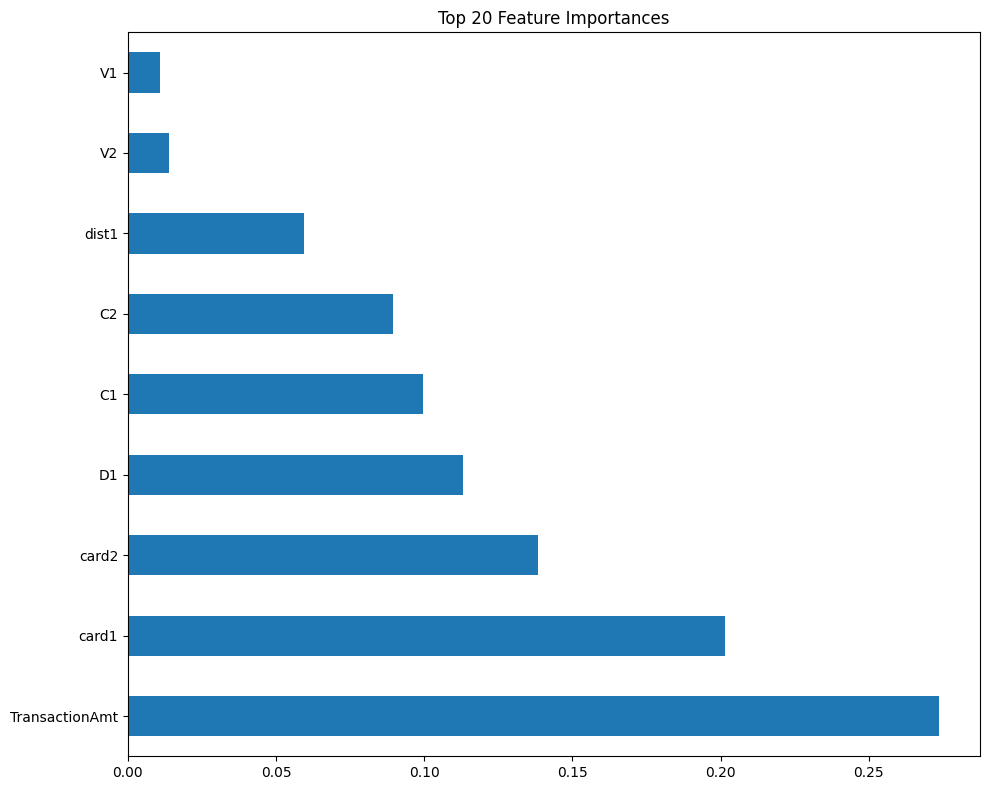

In [ ]:
#9: Feature Importance Visualization (for tree models)
if hasattr(best_model, 'feature_importances_'):
    feat_imp = pd.Series(best_model.feature_importances_, index=X.columns)
    feat_imp.nlargest(20).plot(kind='barh', figsize=(10, 8))
    plt.title("Top 20 Feature Importances")
    plt.tight_layout()
    plt.show()


In [28]:
#10: Final Notes
print("\nWorkflow completed successfully. Model and scaler saved. API ready for deployment.")


Workflow completed successfully. Model and scaler saved. API ready for deployment.
